
## Overfit for Random Forest

#### Dalma Camila Cerro Arrieta
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/leiliu96/)


### Executive Summary

Overfitting arises when a model becomes excessively tailored to the training data, capturing noise and consequently failing to make accurate predictions on unseen data. Within the domain of random forests, overfitting represents a prevalent issue that demands effective mitigation for the development of accurate models capable of delivering good predictions to the problem at hand.

While it's widely acknowledged that overfitting is a common concern across various machine learning models, the central inquiry remains: How can we successfully counteract overfitting, particularly within the context of random forests, to enhance their predictive performance and ensure more robust and reliable outcomes?

By focusing on strategies such as hyperparameter tuning, increasing the forest size, feature selection (optional), cross-validation, error estimation, and post-construction pruning, in thi project we can find a balance between model complexity and generalization. These techniques contribute to improved model robustness and the ability to make more accurate predictions.

### Import Packages


The following code imports the required libraries.

In [71]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import _tree  
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics      
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import time                           
import warnings
warnings.filterwarnings('ignore')                                # supress warnings

### Functions



The required functions are delcared

In [72]:
def add_grid():
    #Function from Professor Michael Pyrcz, https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_DecisionTree.ipynb
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   
    

def runModelWithParams(n_estimators, min_sample_leaf, max_depth, max_features):
    seed = 1367
    #seed = np.random.randint(0, 999999999)
    
    forest_model = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf, max_depth = max_depth, max_features = max_features,random_state = seed)  
    forest_model = forest_model.fit(X_train, y_train)
    y_test_pred = forest_model.predict(X_test)
    y_train_pred = forest_model.predict(X_train)
    test_error = metrics.mean_squared_error(y_test,y_test_pred)
    train_error = metrics.mean_squared_error(y_train, y_train_pred)
    return test_error, train_error    

### Workflow for Overtfit for Random Forest 

### 1. Pre Process Data

Load data to be analyzed. Pre process data for posterior analysis

### 2. Training and Testing Split

Split data into testing and training set.
In this workflow the split between training and testing is of  **75%** for training and **25%** for testing.

### 3. Find Optimal Hyper Parameter - Number of Trees 
  
In this step, we will vary the number of trees in the random forest model and compare the errors in trainig and testing between them. The model with the lowest test error will indicate the optimal number of trees for this data. 

   #### 3.1 Visualization of the Model
   
### 4. Vary Number of Trees and Plot Result Difference of Training and Predicted Data
Show the overfit for different number of trees. In this step, we show that as the number of trees increases, the overfit also increses in the model. After a critic point of number of trees, the overfit stabilizes.

   #### 4.1 Visualizing the Model - Varying Number of Trees
Visualize the overfit for different number of trees (Step 4).

### 5. Find Optimal Hyper Parameter -  Maximum Depth 
  
In this step, we will vary the maximum depth allowed for the trees in the random forest model. We compare the errors between them. The model with the lowest test error will indicate the optimal maximum depth for this data. 

   #### 5.1 Visualization of the Model
Visualize the overfit for different depths in the trees (Step 5).

### 6. Vary Maximum Depth and Plot Ressult Difference of Training and Predicted Data
Show the overfit for different depths in the trees. In this step, we show that a monotonic correlation exist between the maximum depht and overfit in the model. After a critic point of depth, the overfit stabilizes.

   #### 6.1 Visualizing the Model - Varying Maximum Depth
Visualize the overfit for different depths (Step 6).

### 1.  Pre Process Data

The workflow described in this project will use the syntetic dataset "unconv_MV_v2.csv" from: https://github.com/GeostatsGuy/GeoDataSets 

In this workflow, the following features are used to estimate the total production in the reservoir: 
* **Porosity (Por):** The porosity of the rock in each well 
* **Permeability (Perm):** The permeability of the rock in each well 
* **Acoustic Impedance (AI):** Acoustic impedance of the rock 
* **Brittleness (Brittle):** Geomechanic property of the rock 
* **Total Organic Carbon (TOC):** Organic carbon content 
* **Vitrinite Reflactance (VR):** Vitrinite Reflactance of the rock

In [73]:
#df = pd.read_csv("/home/dalma/Documents/Fall2023/Machine Learning/HW8/unconv_MV_v5.csv") 
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v2.csv") 

#### Add Random Error to the Response Feature

Let's add some noise in the data to be capture in the overfit.

Piece of code taken from Professor Michael Pyrcz: "Tree Bagging and Random Forest for Subsurface Modeling in Python" https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb

In [74]:
std_error = 2000   #Add noise to the data
df['Production'] = df['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(df)) # add noise

# prevent negative production weith truncation
num = df._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                     # truncate negative values to 0.0
df.describe().transpose()
df = df.iloc[0:500,1:8]                              # copy all rows and columns 1 through 8, note 0 column is removed
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
Por,500.0,14.89936,2.985967,5.40,12.850000,14.900000,17.01250,23.85000
LogPerm,500.0,1.40010,0.409616,0.18,1.147500,1.380000,1.67000,2.58000
AI,500.0,2.99244,0.563674,1.21,2.590000,3.035000,3.37250,4.70000
Brittle,500.0,49.82382,15.036077,4.50,39.312500,49.595000,59.20750,93.47000
TOC,500.0,0.99800,0.503635,0.00,0.640000,0.960000,1.35000,2.71000
VR,500.0,1.99260,0.307434,0.90,1.820000,2.010000,2.17250,2.84000
Production,500.0,2498.85341,2104.645717,0.00,666.329645,2167.449973,3824.11258,10453.91174


In [95]:
#x_name = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR']
x_name = ['Por', 'Brittle'] #use two features to ensure the overfit of the dataset.
X = pd.DataFrame(df[x_name])


### 2. Training and Testing Split

Split data into testing and training set.
In this workflow the split between training and testing is of  **75%** for training and **25%** for testing.

In [91]:
y = df['Production']
test_size = 0.25
seed = 8924
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=seed)



### 3. Find optimal Hyper Parameter - Number of Trees

In this step, we will vary the number of trees in the random forest model and compare the errors in trainig and testing between them. The model with the lowest test error will indicate the optimal number of trees for this data.

In [92]:
#Random forest hyper parameters
number_of_trees = range(1, 50)
min_samples_leaf = 3
max_depth = 50
max_features=2

# Error
num_trees_test_error = []
num_trees_train_error = []

total_runs = 10

start = time.time()
for n in number_of_trees:
    total_run_train_error = 0
    total_run_test_error = 0
    for run in range(total_runs):
        test_error_i, train_error_i = runModelWithParams(n, min_samples_leaf, max_depth, max_features)
        total_run_train_error += train_error_i
        total_run_test_error += test_error_i
    
    num_trees_train_error.append(total_run_train_error/total_runs)
    num_trees_test_error.append(total_run_test_error/total_runs)
end = time.time()

print('completed')
print('time:', round(end - start,2), 'seconds')

completed
time: 10.72 seconds


In [93]:
num_trees_log_test_error =num_trees_test_error# np.log(num_trees_test_error)
num_trees_log_train_error = num_trees_train_error#np.log(num_trees_train_error)
len(number_of_trees)

49

#### 3.1 Visualizing the Model

Let's plot the ressults for training and testing errors.

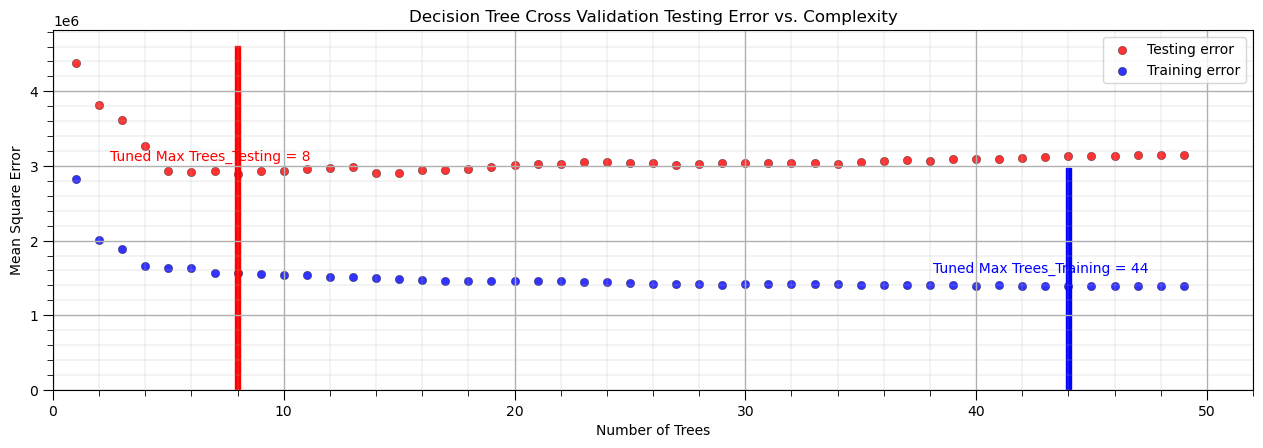

In [94]:
plt.figure(figsize=(8,6))

plt.scatter(number_of_trees, num_trees_log_test_error, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black", label='Testing error')
plt.scatter(number_of_trees, num_trees_log_train_error, s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black", label='Training error')

tuned_n_test = number_of_trees[np.argmin(num_trees_log_test_error)]
max_error_test = np.max(num_trees_log_test_error)
tuned_n_train = number_of_trees[np.argmin(num_trees_log_train_error)]
max_error_train = np.max(num_trees_log_train_error)

plt.arrow(tuned_n_test, 0, 0, 1.05*max_error_test, width=0.2, color='red', head_length=0.0, head_width=0.0)
plt.arrow(tuned_n_train, 0, 0, 1.05*max_error_train, width=0.2, color='blue', head_length=0.0, head_width=0.0)

plt.annotate('Tuned Max Trees_Testing = ' + str(tuned_n_test), (tuned_n_test, num_trees_log_test_error[np.argmin(num_trees_log_test_error)]), xytext=(-20, 10), textcoords='offset points', ha='center', color='red')
plt.annotate('Tuned Max Trees_Training = ' + str(tuned_n_train), (tuned_n_train, num_trees_log_train_error[np.argmin(num_trees_log_train_error)]), xytext=(-20, 10), textcoords='offset points', ha='center', color='blue')

plt.title('Decision Tree Cross Validation Testing Error vs. Complexity'); plt.xlabel('Number of Trees'); plt.ylabel('Mean Square Error')
plt.xlim(0,number_of_trees[-1]+3); plt.ylim(0,1.1*max_error_test); add_grid();plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.6, wspace=0.2, hspace=0.2); plt.show()


In the previous graph, it is possible to observe that the lowest test error number is at 8 tress, and the low trainign error is at 44 trees. As the overfit is incresing, the training erros is drecreasing or estabilizing, and the testing error increases slighly.

### 4. Vary Number of Trees and Plot Result Difference of Training and Predicted Data

Show the overfit for different number of trees. In this step, we show that as the number of trees increases, the overfit also increses in the model. After a critic point of number of trees, the overfit stabilizes.

In [110]:
number_of_trees = [1, 2, 4, 8, 16, 32, 50, 156, 212]
min_samples_leaf = 2
max_depth = 50
max_features=2
n_estimators = 10

forest_models = []
y_train_predictions = []

start = time.time()
for n in number_of_trees:
    model = RandomForestRegressor(n_estimators = n, min_samples_leaf = min_samples_leaf, max_depth = max_depth, max_features = max_features,random_state = seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_train_predictions.append(y_pred)
    forest_models.append(model)    
end = time.time()

print('completed')
print('time:', round(end - start,2), 'seconds')

completed
time: 0.41 seconds


#### 4.1 Visualizing the Model - Varying Number of Trees

Let's visualize the plots for overfit.

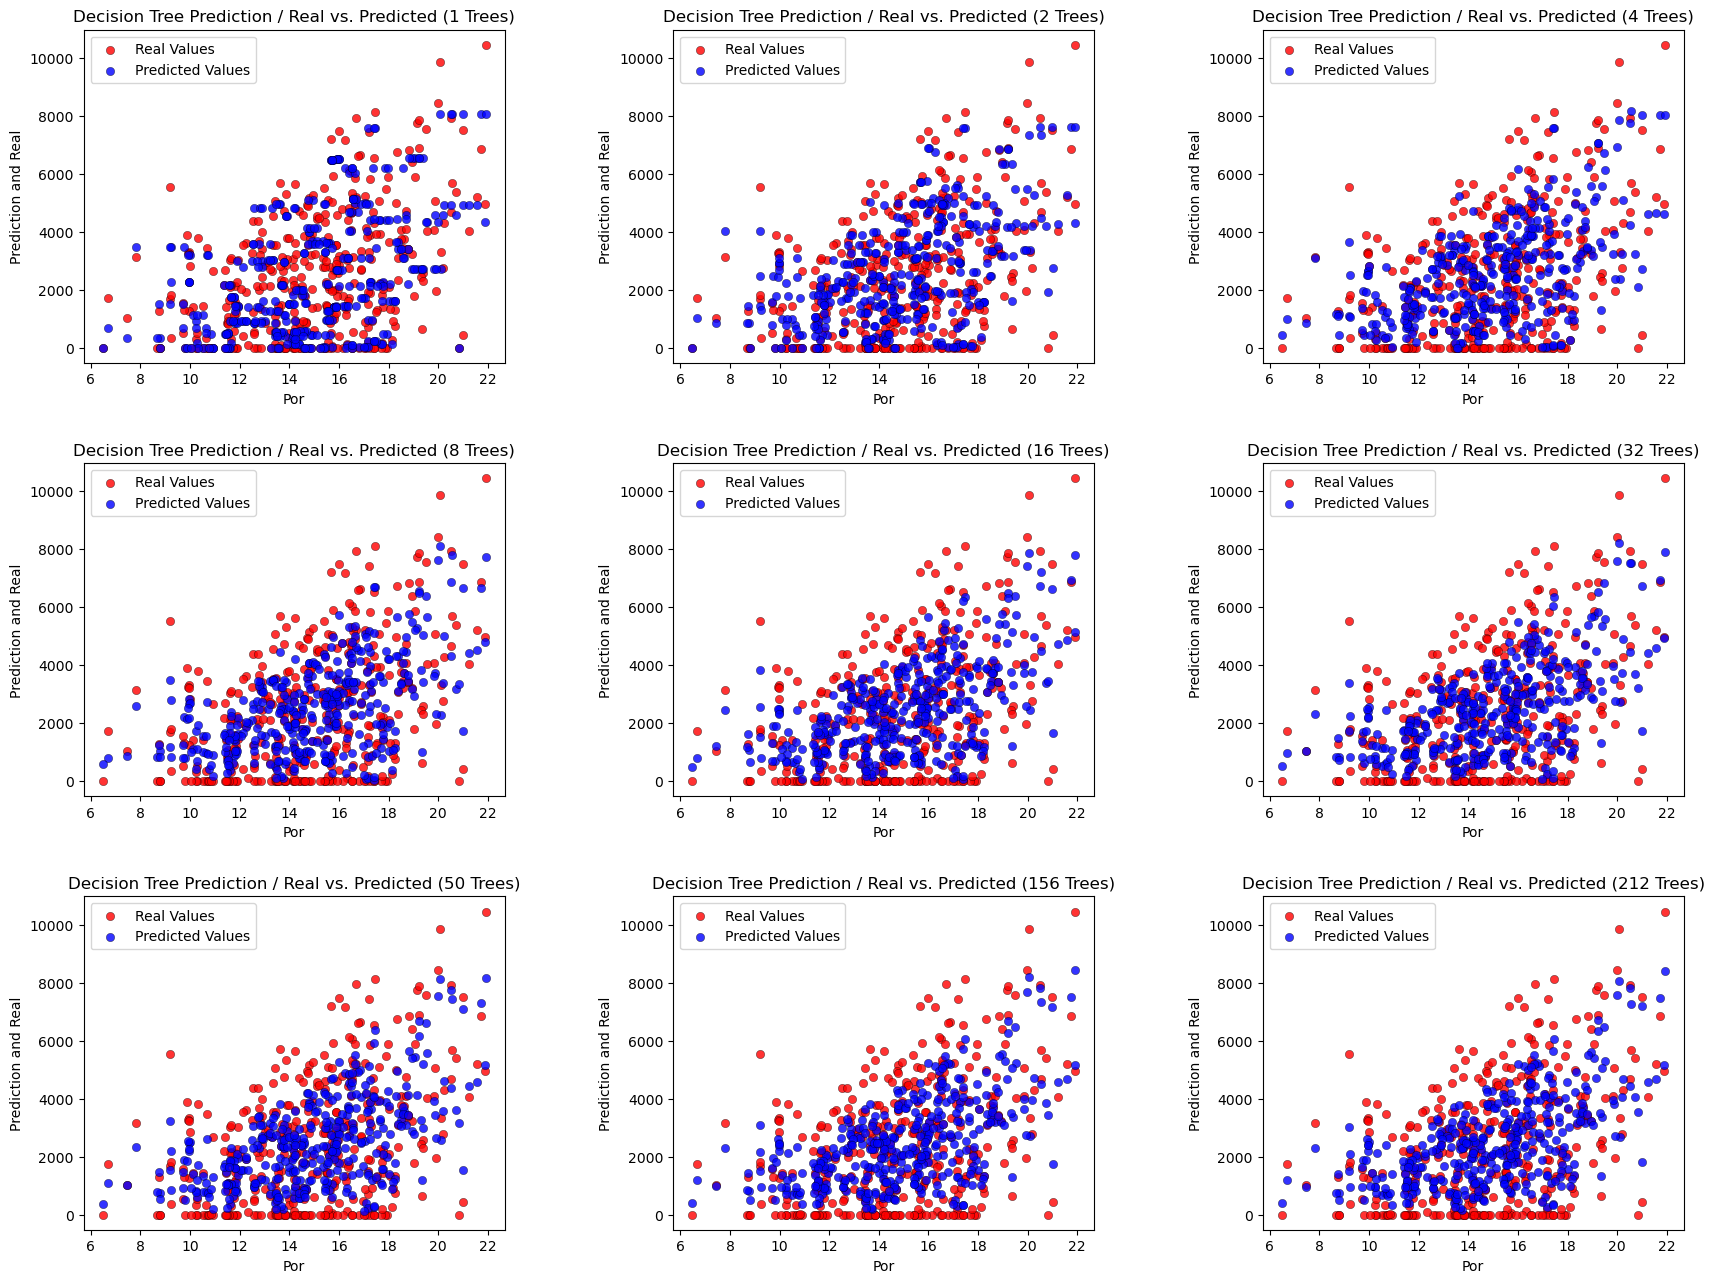

In [111]:
plt.figure(figsize=(8,6))

for index in range(len(y_train_predictions)):
    plt.subplot(3,3,index+1)
    plt.scatter(X_train['Por'],y_train.values,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black", label='Real Values')
    plt.scatter(X_train['Por'],y_train_predictions[index],s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black", label='Predicted Values')
    plt.title(f'Decision Tree Prediction / Real vs. Predicted ({number_of_trees[index]} Trees)') ; plt.xlabel('Por'); plt.ylabel('Prediction and Real');plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

In the above graph, it is possible to observe that as the numer of trees increasses the overfit increases as well. After a determinated number of trees, the model is overfited and it estabilizes.

### 5. Find optimal Hyper Parameter - Maximum Depth

In this step, we will vary the maximum depth of the trees in the random forest model and compare the errors in trainig and testing between them. The model with the lowest test error will indicate the optimal maximum depth for this data. 

In [112]:
number_of_trees = 8
min_samples_leaf = 1
max_depth = range(1, 100)
max_features = 2
# Error
max_depth_test_error = []
max_depth_train_error = []

start = time.time()
for depth in max_depth:
    test_error_i, train_error_i = runModelWithParams(number_of_trees, min_samples_leaf, depth,max_features)
    max_depth_test_error.append(test_error_i)
    max_depth_train_error.append(train_error_i)
end = time.time()

print('completed')
print('time:', round(end - start, 2), 'seconds')

completed
time: 0.98 seconds


In [113]:
max_depth_log_test_error = max_depth_test_error
max_depth_log_train_error = max_depth_train_error

#### 5.1 Visualizing the Model

Let's plot the ressults for training and testing errors.

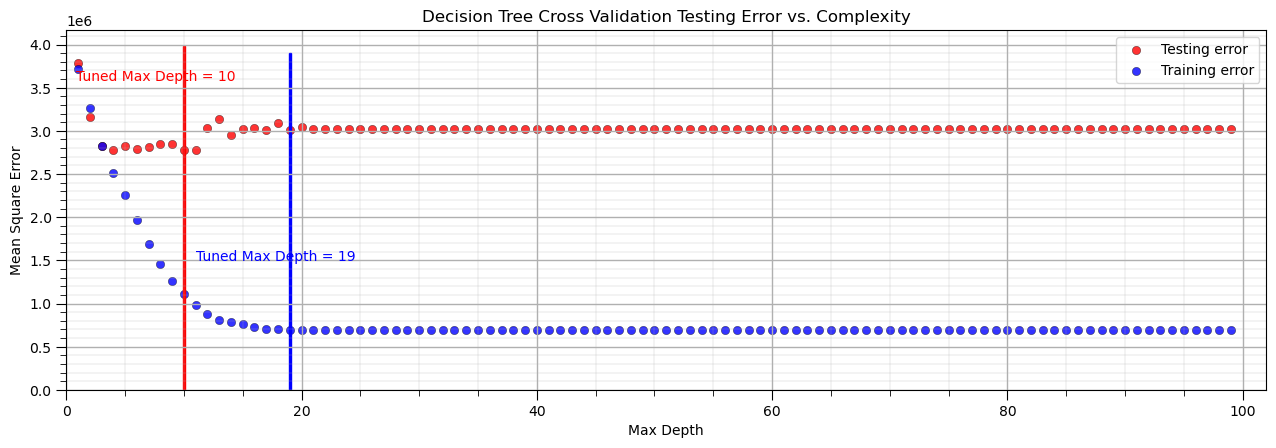

In [114]:
#Code addapted from Professor Michael Pyrcz, https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_DecisionTree.ipynb

plt.figure(figsize=(8,6))

plt.scatter(max_depth,max_depth_log_test_error,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Testing error')
plt.scatter(max_depth,max_depth_log_train_error,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Training error')

tuned_n_test = max_depth[np.argmin(max_depth_log_test_error)]; max_error_test = np.max(max_depth_log_test_error)
tuned_n_train = max_depth[np.argmin(max_depth_log_train_error)]; max_error_train = np.max(max_depth_log_train_error)

plt.arrow(tuned_n_test,0,0,1.05*max_error_test,width=0.2,color='red',head_length=0.0,head_width=0.0)
plt.arrow(tuned_n_train,0,0,1.05*max_error_train,width=0.2,color='blue',head_length=0.0,head_width=0.0)

plt.annotate('Tuned Max Depth = ' + str(tuned_n_test), (tuned_n_test, max_depth_log_test_error[np.argmin(max_depth_log_test_error)]), xytext=(-20, 50), textcoords='offset points', ha='center', color='red')
plt.annotate('Tuned Max Depth = ' + str(tuned_n_train), (tuned_n_train, max_depth_log_train_error[np.argmin(max_depth_log_train_error)]), xytext=(-10, 50), textcoords='offset points', ha='center', color='blue')

plt.title('Decision Tree Cross Validation Testing Error vs. Complexity'); plt.xlabel('Max Depth'); plt.ylabel('Mean Square Error')
plt.xlim(0,max_depth[-1]+3); plt.ylim(0,1.1*max_error_test); add_grid(); plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.6, wspace=0.2, hspace=0.2); plt.show()

In the previous graph, it is possible to observe that the lowest test error number is at depth 10, and the low trainign error is at depht 19. As the overfit is incresing, the training erros is drecreasing or estabilizing, and the testing error increases slighly.

### 6. Vary Maximum Depth and Plot Ressult Difference of Training and Predicted Data

Show the overfit for different dephts in the trees. In this step, we show that as the maximum depht increases, the overfit also increses in the model. After a critic point of maximum depht, the overfit stabilizes.

In [115]:
number_of_trees = 10
min_samples_leaf = 1
max_depth = [1, 2, 4, 8, 16, 32, 128, 256, 512]
max_features=2
n_estimators = 10

forest_models = []
y_train_predictions = []
y_test_predictions=[]

start = time.time()
for depth in max_depth:
    model = RandomForestRegressor(n_estimators = number_of_trees, min_samples_leaf = min_samples_leaf, max_depth = depth, max_features = max_features,random_state = seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_train_predictions.append(y_pred)
    y_test_predictions.append(model.predict(X_test))
    forest_models.append(model)    
end = time.time()

print('completed')
print('time:', round(end - start, 2), 'seconds')

completed
time: 0.11 seconds


#### 6.1 Visualizing the Model - Varying Maximum Depth

Let's visualize the plots for overfit.

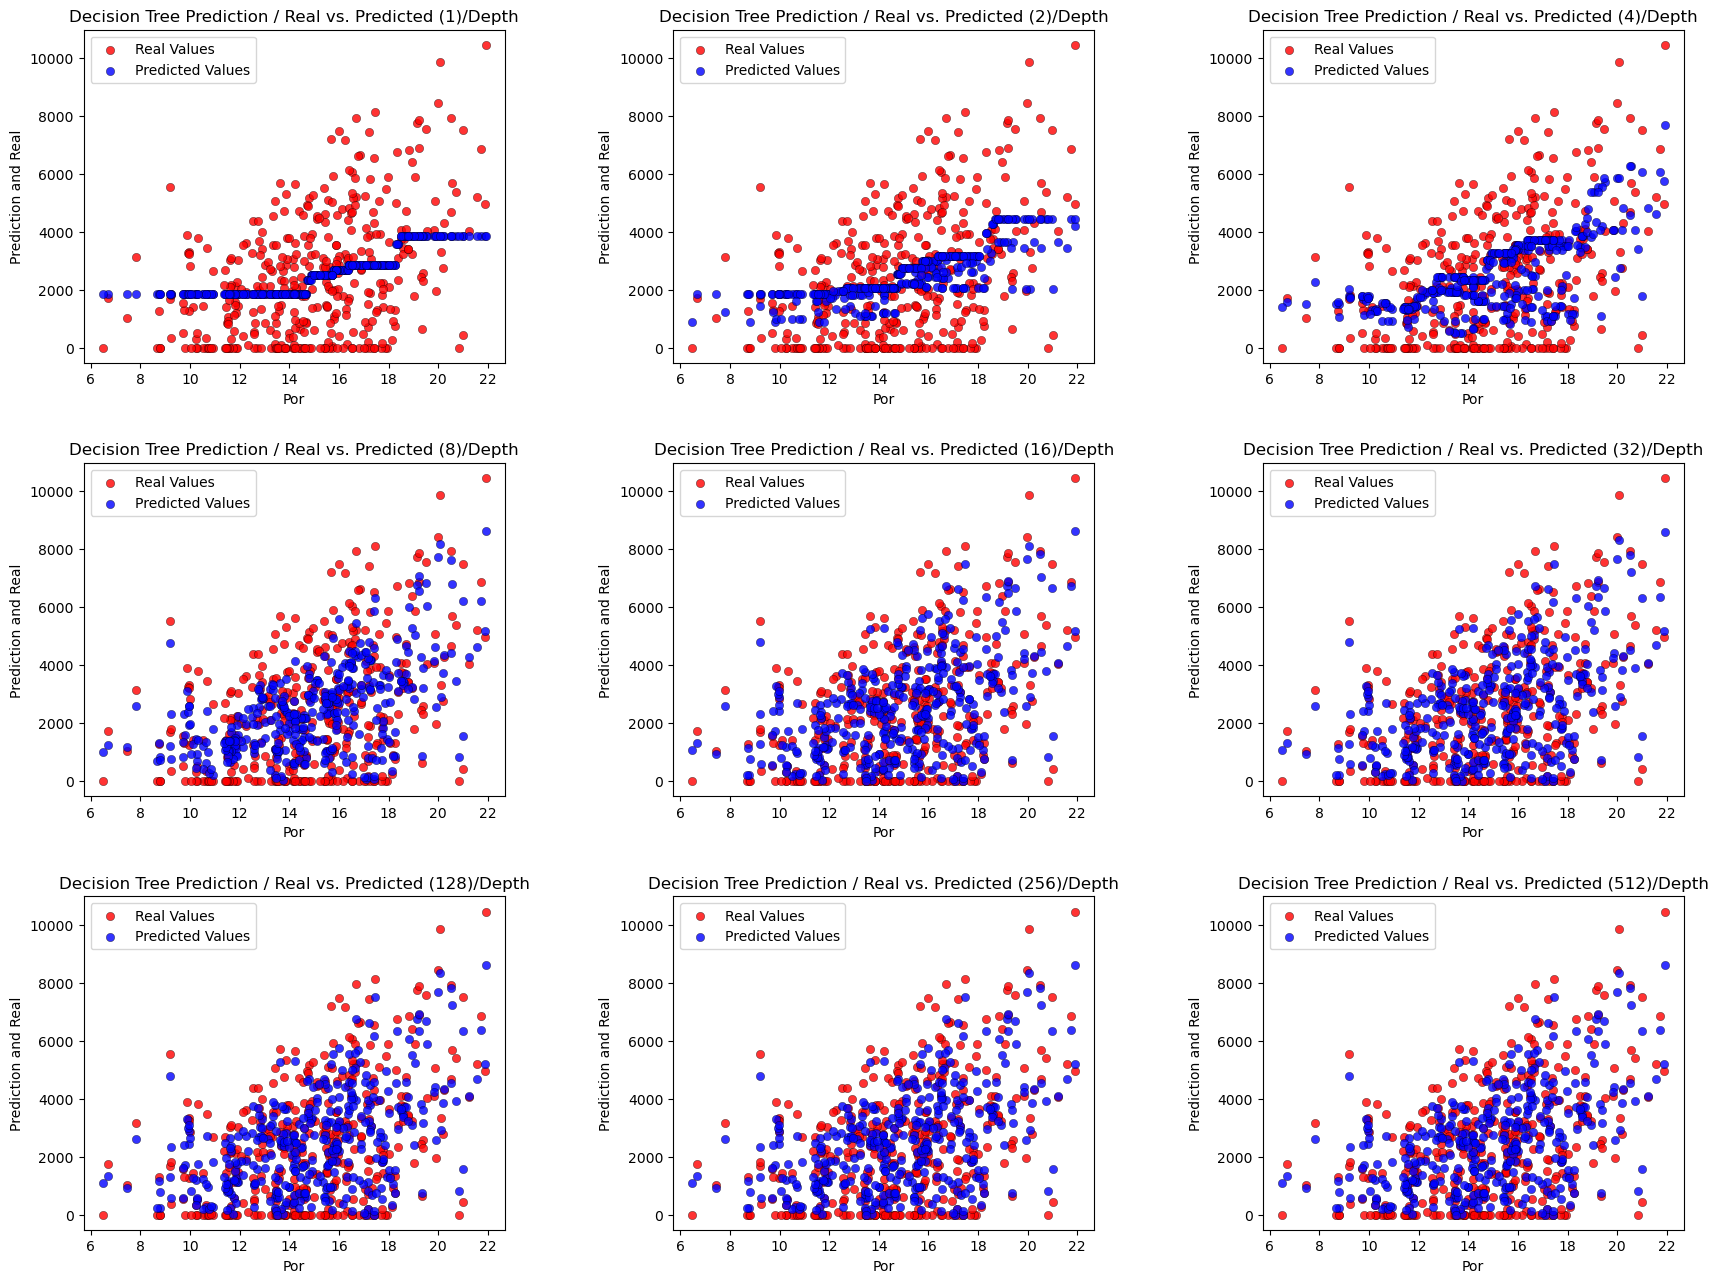

In [116]:
plt.figure(figsize=(8,6))

for index in range(len(y_train_predictions)):
    plt.subplot(3,3,index+1)
    plt.scatter(X_train['Por'],y_train.values,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Real Values')
    plt.scatter(X_train['Por'],y_train_predictions[index],s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Predicted Values')
    plt.title(f'Decision Tree Prediction / Real vs. Predicted ({max_depth[index]})/Depth') ; plt.xlabel('Por'); plt.ylabel('Prediction and Real');plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

In the above graph, it is possible to observe that as the depht of trees increasses the overfit increases as well. After a determinated maximum depth, the model is overfited and it estabilizes.

### Results
In the previous workflow two different approaches for overfit in random forest were analyzed.
In the first approach, a comparisson between MSE in training and testing data showed that while the model captures noise in the training data, the MSE in training is reduced and MSE in testing increases. The former behaviour can be observed until a critical point, where the number of trees have captured all the noise and the overfit stabilizes. Once the overfit is stabilized, the MSE in training and testing are also stabilized in the model. A similar comparison is made for maximum depth in the model. In this comparisson it is possible to observe that after a critical maximum depth in the model is reach, the overfit stabilizes as well as MSE in training and testing data.
In the second approach, a comparison between the prediction values and actual data points is made. Figures 4.1 and 6.1 show the results for variation in number of trees and maximum depth until the model no discernable difference is observed when increasing the hyperparameter. In the figures above mentioned,it is possible to observed that once the critical point where the overfit is reached, the training a and prediction data tend to overlap.


I hope this was helpful,

*Dalma Cerro*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
